# Plan




1. Get gradients on transition matrix for n-steps [X]
2. Figure out what to multiply a vector by to obtain skew-symmetric matrix - [x] 
    -1. A~
3. Use caley transform to generate a unitary matrix - [x] 
4. Run whole thing through jax to get PI representation [X]

In [154]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.optimize as op
from functools import partial
seaborn.set(font_scale=1.5,style='ticks')

# Run with jax

In [160]:
dim = 4
nT = 9
x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(9)])

In [161]:
#plt.plot(x[:,1])
#plt.yscale('symlog')

In [162]:
Ahat = np.random.normal(size=(dim,dim))


In [163]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


In [164]:
def predict(Ahat,x,y,n,dim):
    Ahat = jnp.reshape(Ahat,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(Ahat,n),x)-y)**2)


predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
grad_predict_funs = [grad(i) for i in predict_funs]

In [165]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [166]:
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [167]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (np.eye(dim) - skewM)@np.linalg.inv(np.eye(dim)+skewM)

In [168]:
def predict_all(Ahat,x,predict_funs,grad_predict_funs,dim):
    Ahat = Ahat.reshape(dim,dim)
    #print(Ahat.shape)
    err = 0
    nT = len(x)
    k = 0
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict_funs[n_fwd](Ahat,x[start_state],x[pred_state])
            k += 1
    return err/k


def predict_all_grad(Ahat,x,predict_funs,grad_predict_funs,dim):
    
    #n_ = len(Ahat.flatten())
    Ahat = Ahat.reshape(dim,dim)
    J = np.zeros(Ahat.shape)
    #print(J.shape)
    nT = len(x)
    k = 0
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT):
            n_fwd =  pred_state-start_state 
            #print(n_fwd,J.shape,)
            #print(start_state,pred_state,n_fwd)
            J = J + grad_predict_funs[n_fwd](Ahat,x[start_state],x[pred_state])
            k+= 1
    #J = J/k
    return J.flatten()
    

In [169]:
predict_funs[1](A,x[0],x[1])

DeviceArray(2.5757174e-14, dtype=float32)

In [170]:
dim*(dim-1)/2

6.0

In [171]:
#%%timeit
op.approx_fprime(Ahat.flatten(),
                 predict_all,
                 1e-4,
                 *(x,predict_funs,grad_predict_funs,dim)
            )

array([ -4208.984375 ,  -1406.25     ,  -2617.1875   ,   3510.7421875,
        -4453.125    ,  26386.71875  ,  -7280.2734375,  12138.671875 ,
         1494.140625 ,   3422.8515625,    649.4140625,    361.328125 ,
        14267.578125 ,   3847.65625  ,   8994.140625 , -11318.359375 ])

In [172]:
grad_predict_all = grad(predict_all)

In [112]:
#%%timeit
grad_predict_all(Ahat,x,predict_funs,grad_predict_funs,dim)

DeviceArray([[  50.660797 ,  -51.766518 ,  -49.855736 ,  -15.295107 ],
             [  68.16792  ,    7.076019 ,  114.02746  ,  -13.886376 ],
             [ -43.350094 ,  -28.661837 ,  -48.217873 , -101.0971   ],
             [  23.022648 ,  -36.4674   ,    4.2988143,   11.729656 ]],            dtype=float32)

In [113]:
predict_all_grad(Ahat,x,predict_funs,grad_predict_funs,dim)

DeviceArray([ 1280.3977  , -1992.4744  , -1375.2327  , -1047.0925  ,
              3219.325   ,   436.52008 ,  5440.554   ,  -101.73405 ,
             -1393.2512  , -1895.0182  , -2684.1511  , -4232.7744  ,
               830.14124 , -1275.2408  ,   669.2723  ,   -23.406904],            dtype=float32)

In [114]:
params = np.random.normal(size=(1,int(dim*(dim-1)/2)))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (x,predict_funs,grad_predict_funs,dim),
           jac=grad_predict_all,
           method='Newton-CG'
           )
print(res.message)

ValueError: cannot reshape array of size 6 into shape (4,4)

In [115]:
res.message

'Desired error not necessarily achieved due to precision loss.'

In [116]:
Ainf = res.x.reshape(dim,dim)

ValueError: cannot reshape array of size 3 into shape (4,4)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

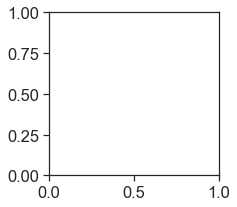

In [117]:
plt.figure(figsize=(14,3))

for i in range(dim):
    
    plt.subplot(1,dim,i+1)
    plt.plot((np.linalg.matrix_power(Ainf,1)@x)[:,i],marker='.')
    plt.plot((np.linalg.matrix_power(A,1)@x)[:,i],marker='.')
    #plt.

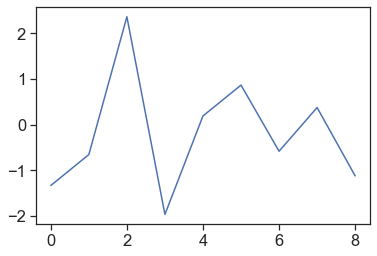

In [118]:
plt.plot((np.linalg.matrix_power(A,5)@x)[:,2])

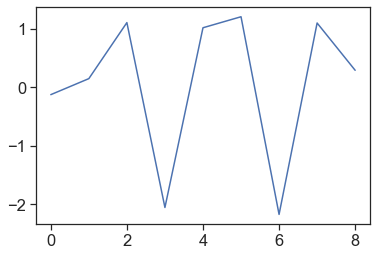

In [119]:
plt.plot(x[:,0])

In [120]:
a = np.random.normal(size=(5,1))
H = np.triu(np.ones([3,3,15]))

# Now do it properly with constraints

In [121]:
def get_basis_tensor(dim):
    """ Returns a tensor that forms a basis for skew symmetric matrices.
        Use np.einsum('i...,i...',params,basis_tensor) to construct this
        matrix
    """
    basis_tensor = []
    for i in range(dim):
        for j in range(i+1,dim):
            bi =  np.zeros([dim,dim])
            bi[i,j] = -1
            bi = bi -bi.T
            basis_tensor.append(bi.T)
    basis_tensor = np.array(basis_tensor)
    return np.asarray(basis_tensor)


In [122]:
def caley_transform(skewM,dim):
    """ Perform Caley transform"""
    return (jnp.eye(dim) - skewM)@jnp.linalg.inv(jnp.eye(dim)+skewM)

In [123]:
params.shape

(1, 6)

In [124]:
def predict(T,x,y,n,dim):
    transition_matrix = jnp.reshape(T,(dim,dim))
    return jnp.sum((jnp.dot(jnp.linalg.matrix_power(transition_matrix,n),x)-y)**2)


#predict_funs = [partial(predict,n=i,dim=dim) for i in range(9)]
#grad_predict_funs = [grad(i) for i in predict_funs]

In [125]:
def predict_all(params,x,dim,basis_tensor):

    err = 0
    nT = len(x)
    k = 0
    skewM = jnp.einsum('i...,i...',params,basis_tensor)
    M = caley_transform(skewM,dim)
    #print(M.shape)
    for start_state in range(nT):
        for pred_state in range(start_state+1,nT-start_state):
            n_fwd = pred_state-start_state 
            err += predict(M,x[start_state],x[pred_state],n_fwd,dim)
            k += 1
    mse = err/k
    print(mse)
    return mse


In [126]:
x.shape

(9, 4, 1)

In [127]:
A

array([[-0.39807324, -0.67183496,  0.58877936, -0.20860093],
       [ 0.31827791, -0.48443422, -0.55045945, -0.60084695],
       [-0.85849771,  0.1672618 , -0.45181787, -0.17568664],
       [ 0.05673235,  0.53477543,  0.38235308, -0.75140056]])

In [128]:
grad_predict_all = grad(predict_all)

In [129]:
a = grad_predict_all(jnp.array(res.x),x,dim,basis_tensor)

ValueError: Size of label 'i' for operand 1 (3) does not match previous terms (6).

In [130]:
a

array([[ 2.91748485],
       [ 0.25283541],
       [ 0.89589914],
       [-0.38530085],
       [ 1.06595425]])

In [131]:
def grad_wrapper(params,x,dim,basis_tensor):
    grad = grad_predict_all(jnp.array(params),x,dim,basis_tensor)
    grad = np.array(grad)
    print(grad)
    return grad

## Generate Data

In [132]:
dim = 3
nT = 9

frac = .3

x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])

x = frac*x + (1-frac)*np.random.normal(size=x.shape)

basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [133]:
I = np.eye(dim)
skewORG = (I-A)@np.linalg.inv(I+A)

In [134]:
params = []

n = skewORG.shape[0]
for i in range(n):
    for j in range(i+1,n):
        params.append(skewORG[i,j])
    

In [135]:
params

[0.1094573649933412, 0.05869872211197402, -0.8042751850047836]

In [136]:
predict_all(params,x,dim,basis_tensor)

2.8932862


DeviceArray(2.8932862, dtype=float32)

In [137]:
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [138]:
grad_predict_all = grad(predict_all)

In [139]:
#np.einsum('i...,i...',params,basis_tensor)

In [140]:
#out = op.brute(predict_all,
#               [(0,1)]*3,
#               (x,dim,basis_tensor))

In [141]:
n_params = int(dim*(dim-1)/2)
params = np.random.normal(size=(n_params))# + np.eye(dim)
res = op.minimize(predict_all,
           params,
           (x,dim,basis_tensor),
           jac=grad_wrapper,
           method='BFGS'
           )
print(res.message)

3.8161235
Traced<ConcreteArray(3.8161234855651855, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(3.8161235, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c40f0f670>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c4108b890; to 'JaxprTracer' at 0x7f9c4108b6b0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c4102a530>)
[ 0.36031246 -0.25205284  0.17317748]
3.6064575
Traced<ConcreteArray(3.606457471847534, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(3.6064575, dtype=float3

Traced<ConcreteArray(2.3578670024871826, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(2.357867, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c40e0c6a0>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c410ac050; to 'JaxprTracer' at 0x7f9c41093e30>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c4108d8b0>)
[-1.9278886  -0.71389335 -0.6168957 ]
1.9366556
Traced<ConcreteArray(1.9366556406021118, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.9366556, dtype=float32)
  tange

[ 0.0018439   0.00170398 -0.00953776]
1.5112541
Traced<ConcreteArray(1.5112537145614624, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112537, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c40e20630>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c60729b30; to 'JaxprTracer' at 0x7f9c709e3650>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c40c761b0>)
[ 2.0363927e-04  1.6689301e-05 -3.8874149e-04]
1.5112536
Traced<ConcreteArray(1.5112535953521729, dtype=float32)>with<JVPTrace(level=2/0)> wit

Traced<ConcreteArray(1.5112543106079102, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112543, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c50cb8630>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c20f42ef0; to 'JaxprTracer' at 0x7f9c20f42dd0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c4113d1f0>)
[-9.5069408e-06  9.4175339e-06  2.6106834e-05]
1.5112536
Traced<ConcreteArray(1.5112535953521729, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112536, dtype=float3

Traced<ConcreteArray(1.5112535953521729, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112536, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c50cb8630>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c40f2aef0; to 'JaxprTracer' at 0x7f9c40f2ad10>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c20c95e70>)
[-1.0579824e-05  1.0251999e-05  2.9325485e-05]
1.5112538
Traced<ConcreteArray(1.511253833770752, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112538, dtype=float32

Traced<ConcreteArray(1.5112535953521729, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112536, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c40eec640>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c41008f50; to 'JaxprTracer' at 0x7f9c41008d70>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c4118e570>)
[-1.03712082e-05  1.04904175e-05  2.93850899e-05]
1.5112538
Traced<ConcreteArray(1.511253833770752, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112538, dtype=floa

[-1.03712082e-05  1.04904175e-05  2.93850899e-05]
1.5112536
Traced<ConcreteArray(1.5112535953521729, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112536, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c40ff9630>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c50deca10; to 'JaxprTracer' at 0x7f9c50dec830>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c40edc9f0>)
[-1.03712082e-05  1.04904175e-05  2.93850899e-05]
1.5112536
Traced<ConcreteArray(1.5112535953521729, dtype=float32)>with<JVPTrace(

Traced<ConcreteArray(1.5112535953521729, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112536, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c40b29630>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c41091fb0; to 'JaxprTracer' at 0x7f9c41091dd0>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c40d89070>)
[-1.03712082e-05  1.04904175e-05  2.93850899e-05]
1.5112538
Traced<ConcreteArray(1.511253833770752, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112538, dtype=floa

[-1.03712082e-05  1.04904175e-05  2.93850899e-05]
1.5112536
Traced<ConcreteArray(1.5112535953521729, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray(1.5112536, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f9c50cb8630>, invars=(Traced<ConcreteArray(20.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=1/0)>), outvars=[<weakref at 0x7f9c20f69590; to 'JaxprTracer' at 0x7f9c20f69350>], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'jvp(true_divide)', 'donated_invars': (False, False), 'inline': True, 'call_jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div b a in (c,) }}, source_info=<jaxlib.xla_extension.Traceback object at 0x7f9c40edcb70>)
[-1.03712082e-05  1.04904175e-05  2.93850899e-05]
1.5112536
Traced<ConcreteArray(1.5112535953521729, dtype=float32)>with<JVPTrace(

In [142]:
A

array([[ 0.98143946, -0.07489382, -0.17654321],
       [ 0.1884963 ,  0.20730864,  0.95994389],
       [-0.03529493, -0.97540455,  0.21757809]])

In [143]:
print(res.message)

Desired error not necessarily achieved due to precision loss.


In [144]:
out = res.x

In [145]:
skewM = np.einsum('i...,i...',out,basis_tensor)
Ainf = caley_transform(skewM,dim)

In [146]:
assert np.all(skewM==-skewM.T)
print(np.all(skewM==-skewM.T))

True


In [147]:
np.linalg.det(Ainf)

0.9999999

In [148]:
np.allclose(np.linalg.norm(Ainf,axis=0),1)

True

In [149]:
np.min([np.sum(np.abs(np.linalg.matrix_power(Ainf,i)-np.eye(3))) for i in range(1,150)])

0.07483591388700006

In [150]:
np.min([np.sum(np.abs(np.linalg.matrix_power(Ainf,i)-np.eye(3))) for i in range(150)])

0.0

In [151]:
(np.linalg.matrix_power(A,1)@x).shape

(9, 3, 1)

In [152]:
np.sum(((np.linalg.matrix_power(Ainf,1)@x)-(np.linalg.matrix_power(A,1)@x))**2)

3.0899680646632373

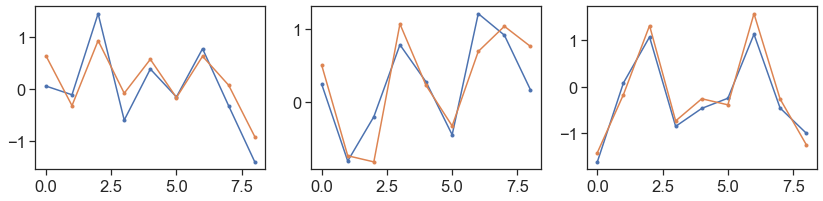

In [153]:
plt.figure(figsize=(14,3))

for i in range(dim):
    
    plt.subplot(1,dim,i+1)
    plt.plot((np.linalg.matrix_power(Ainf,1)@x)[:,i],marker='.')
    plt.plot((np.linalg.matrix_power(A,1)@x)[:,i],marker='.')
    #plt.

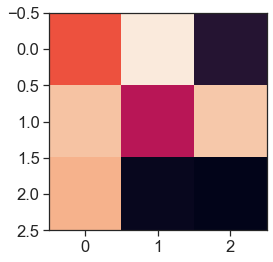

In [151]:
plt.imshow(Ainf)

# Check MCMC fit

# Get this to work with cell activity with structured noise

In [692]:
n_neurons = 120
dim = 3
nT = 9

frac_noise_dynamics = .3

x0 = np.random.normal(size=(dim,1))
A_ = np.random.normal(size=(dim,dim))

A = np.zeros([dim,dim])

for i in range(dim):
    A[i,i:] = A_[i:,i]
    A[i:,i] = -A_[i:,i]
    
A[np.diag_indices_from(A)] = 0
A = (np.eye(dim)-A)@np.linalg.inv(np.eye(dim)+A)

x = np.array([np.linalg.matrix_power(A,i)@x0 for i in range(nT)])

x = frac_noise_dynamics*x #+ (1-frac_noise_dynamics)*np.random.normal(size=x.shape)


W = np.random.normal(size=(n_neurons,dim))
basis_tensor = get_basis_tensor(dim)
n_bases = basis_tensor.shape[0]

In [693]:
def get_spatial_tuning(poke_pos,peak_loc,width):
    """"""
    #for i in range(9):
    distance_matrix = np.abs((poke_pos[peak_loc]-poke_pos)**2).sum(axis=1)
    fr = norm(scale=width).pdf(distance_matrix)
    return fr#distance_matrix
        
def get_task_tuning_line(seq,peak_loc,width):
    task_dists = np.abs(peak_loc-np.arange(9))
#     fr = norm(scale=width).pdf(task_dists)
    fr = np.sin(task_dists)
    return fr[seq]#task_dists[seq]#[task_dists[i] for i in seq]#fr#[fr[i] for i in seq]

In [694]:
act_matrix = []
for nix in range(n_neurons):
    peak_space = np.random.randint(0,9)
    std_space = np.random.randint(1000,12000)
    
    lamda1 = get_spatial_tuning(poke_pos,peak_space,std_space)
    lamda1 = lamda1/np.max(lamda1)
    
    #peak_t1 = np.random.randint(0,9)
    #std_t1 = np.random.randint(3,6)
    #lamda2 = 1*get_task_tuning_line(seq01,peak_t1,std_t1)
    #lamda2 = lamda2/np.max(lamda2)
    #task_tuning = 
    
    
    #peak_t2= np.random.randint(0,9)
    #std_t2 = np.random.randint(1,40)/10.
    w1 = np.random.normal()
    w2 = np.random.normal()
    activity = lamda1 + lamda2 + np.random.normal(scale=.1,size=9)
    act_matrix.append(activity.copy())
act_matrix = np.array(act_matrix).T

NameError: name 'poke_pos' is not defined